.



# Project: European Soccer Database Analysis 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The database contents:

- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

After review database description in <a href = https://www.kaggle.com/hugomathien/soccer/home> Kaggle </a> we decided to download it and get closer look with <a href = https://sqlitebrowser.org/> DB browser </a>.
Then the following questions were raised:
>1. Is it more likely for a team to win in the home matches than in a way? 
2. If we form a Combined Overall Rating(Team_COR) of a team as a sum of Overall Ratings of each its players is it more likely for a team with a bigger COR to win a match?
3. How the match results correlate with COR?


Let's get started to find the answers

<a id='wrangling'></a>
# Data Wrangling

### Building data frames and clean data

In [1]:
# Import neccasary packages
import timeit
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# the 'magic function' to set the plots directly below the code cells that produce it
%matplotlib inline 

# set the background style of plots
import seaborn as sns
sns.set_style('darkgrid') 


In [2]:
# make a connection with database uploaded in the home directory
conn = sqlite3.connect('database.sqlite')
print('Connection success', conn)


Connection success <sqlite3.Connection object at 0x00000000096DE730>


In [3]:
# read the names of tables in the database
tables_list = pd.read_sql('SELECT * FROM sqlite_master WHERE type = "table"', conn); tables_list



,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


>Based on the purpose of analysis we need to use three of the tables mentioned above:
- **'Team'** : to store main features for further prediction
- **'Match'** : to  produce and store features we need to compute main features
- **'Player_Attributes'** : to get data to calculate **'Team_COR'** feature for Match table

# df_Player_Attribute

In [4]:
# get data from 'Player_Attributes' table and inspect it
df_Player_Attribute = pd.read_sql('SELECT * FROM Player_Attributes', conn)
df_Player_Attribute.shape

(183978, 42)


>We need only four columns from this dataset: 
- **'date'**
- **'player_fifa_api_id'**, 
- **'player_api_id'** 
- **'overall_rating'**

>So, let's drop other columns.

In [5]:
df_Player_Attribute = df_Player_Attribute.loc[:,['player_fifa_api_id','player_api_id','date','overall_rating']]
df_Player_Attribute.shape

(183978, 4)

In [6]:
#rearange the columns
df_Player_Attribute = df_Player_Attribute[['date','player_fifa_api_id','player_api_id','overall_rating']]

In [7]:
#size of dataset
df_Player_Attribute.head(1)

,date,player_fifa_api_id,player_api_id,overall_rating
0,2016-02-18 00:00:00,218353,505942,67.0


In [8]:
#check if some value is NAN
df_Player_Attribute.isnull().sum()

date                    0
player_fifa_api_id      0
player_api_id           0
overall_rating        836
dtype: int64

In [9]:
#drop the rows with missing values
df_Player_Attribute = df_Player_Attribute.dropna()

### Overall player rating
We assume that overall players rating takes no significant changes for one year. So we can drop
not necessary data from this data frame

In [10]:
# keep just data of the year in 'date' column 
df_Player_Attribute['date'] = df_Player_Attribute['date'].str.slice(0,4)


In [11]:
# drop rows considered duplicated  by identified data duplicates in columns 'date' and 'player_api_id'
df_Player_Attribute = df_Player_Attribute.drop_duplicates(subset = ['date','player_api_id'])


In [12]:
#sort data frame by 'date' column.
df_Player_Attribute.sort_values('date', inplace = True)

In [13]:
#drop data for 2007 year, because, 'Match' database has no data for this year
df_Player_Attribute = df_Player_Attribute.drop(labels = df_Player_Attribute.query('date == "2007"').index)

In [14]:
#reset data frame's index
df_Player_Attribute = df_Player_Attribute.reset_index(drop = True)

In [15]:
df_Player_Attribute.head(2)


,date,player_fifa_api_id,player_api_id,overall_rating
0,2008,150035,39440,67.0
1,2008,177128,41236,59.0


In [16]:
df_Player_Attribute.nunique()

date                      9
player_fifa_api_id    11058
player_api_id         11058
overall_rating           59
dtype: int64

In [17]:
#check data types
df_Player_Attribute.dtypes

date                   object
player_fifa_api_id      int64
player_api_id           int64
overall_rating        float64
dtype: object

In [18]:
# set data type as integer
df_Player_Attribute = df_Player_Attribute.astype('int64')
df_Player_Attribute.dtypes

date                  int64
player_fifa_api_id    int64
player_api_id         int64
overall_rating        int64
dtype: object

In [19]:
df_Player_Attribute.shape

(61999, 4)

In [20]:
#final check for data quality
df_Player_Attribute.describe()

,date,player_fifa_api_id,player_api_id,overall_rating
count,61999.000000,61999.000000,61999.000000,61999.000000
mean,2012.114324,160563.811965,121473.151148,68.170019
std,2.450252,56013.512413,127119.360748,6.899645
min,2008.000000,2.000000,2625.000000,35.000000
25%,2010.000000,148550.500000,33639.000000,64.000000
50%,2012.000000,178628.000000,62382.000000,68.000000
75%,2014.000000,194989.000000,178291.000000,73.000000
max,2016.000000,234141.000000,750584.000000,94.000000


>The **'df_Player_Attribute'** data frame is ready. Let's do an inspection of data in 'Team'  table

# df_Team

In [21]:
df_Team = pd.read_sql('SELECT * FROM Team', conn)
df_Team.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [22]:
#size of dataset
df_Team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


>The columns **'team_fifa_api_id' and 'id'** is not necessary for our analysis, so let's drop it and set all data type as an integer

In [23]:
df_Team = df_Team.drop(['id','team_fifa_api_id'], axis = 1)
df_Team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 3 columns):
team_api_id        299 non-null int64
team_long_name     299 non-null object
team_short_name    299 non-null object
dtypes: int64(1), object(2)
memory usage: 7.1+ KB


>The **'df_Team'** data frame is ready. Let's do an inspection of data in 'Match' table

# df_Match

In [24]:
df_Match = pd.read_sql('SELECT * FROM Match', conn)
df_Match.shape

(25979, 115)

>After inspection of the database in DB browser we find that the 'Match" table has too many columns and we do not need all of them. Let's get rid of what we don't need.


In [25]:
# build a list of columns that we need
Columns_List = ['date',
                'match_api_id', 
                'home_team_api_id', 
                'away_team_api_id', 
                'home_team_goal', 
                'away_team_goal', 
                'home_player_1', 
                'home_player_2',
                'home_player_3',
                'home_player_4',
                'home_player_5',
                'home_player_6',
                'home_player_7',
                'home_player_8',
                'home_player_9',
                'home_player_10',
                'home_player_11',
                'away_player_1',
                'away_player_2',
                'away_player_3',
                'away_player_4',
                'away_player_5',
                'away_player_6',
                'away_player_7',
                'away_player_8',
                'away_player_9',
                'away_player_10',
                'away_player_11']

In [26]:
# drop the columns that not in Columns_List
df_Match.drop([x for x in df_Match.columns.tolist() if x not in Columns_List],1, inplace = True)

# drop the rows with missing values 
df_Match = df_Match.dropna()
df_Match.shape

(21374, 28)

In [27]:
df_Match.head(2)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
145,2009-02-27 00:00:00,493017,8203,9987,2,1,38327.0,67950.0,67958.0,67959.0,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
153,2009-03-08 00:00:00,493025,9984,8342,1,3,36835.0,37047.0,37021.0,37051.0,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0


In [28]:
# keep just year and sort data frame by 'date' column
df_Match['date'] = df_Match['date'].str.slice(0,4)
df_Match.sort_values('date', inplace = True)

In [29]:
#set data types 
df_Match = df_Match.astype('int64')


In [30]:
#reset index
df_Match.reset_index(drop = True, inplace = True)

In [31]:
df_Match.head(2)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,2008,499349,8722,9823,0,3,26173,39810,97491,38215,...,39774,30459,33085,30872,35988,25365,38843,30894,30709,30638
1,2008,539652,9885,8686,2,0,39566,30861,41412,41884,...,27693,30453,41023,24130,30682,37545,27695,30747,38717,38822


In [32]:
df_Match.describe()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
count,21374.000000,2.137400e+04,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,...,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000
mean,2012.281838,1.251568e+06,9977.827781,10048.081969,1.557266,1.175073,76742.444231,107817.580986,92216.855432,94926.233976,...,108366.129690,91374.264012,95044.389164,110431.136989,103257.580284,98863.244222,110122.267708,112000.940722,107360.801722,105299.890053
std,2.257115,4.805469e+05,13147.549402,13579.703256,1.303900,1.149778,87772.824162,113107.414135,103610.454488,103048.540630,...,114054.960365,102137.928138,103716.234711,113137.976484,111596.132480,108734.466569,117333.639465,116984.819126,113083.611508,111132.868797
min,2008.000000,4.831300e+05,1601.000000,1601.000000,0.000000,0.000000,2984.000000,2802.000000,2752.000000,2752.000000,...,2790.000000,2752.000000,2752.000000,2790.000000,2802.000000,2625.000000,2770.000000,2770.000000,2770.000000,2802.000000
25%,2010.000000,8.401552e+05,8530.000000,8530.000000,1.000000,0.000000,30622.000000,32553.000000,30459.000000,30617.000000,...,32579.000000,30453.000000,30593.000000,33338.000000,31011.000000,30907.000000,32761.000000,33435.250000,32343.000000,32674.000000
50%,2012.000000,1.227826e+06,9747.000000,9747.000000,1.000000,1.000000,37900.000000,42258.000000,39643.000000,40735.000000,...,42258.000000,39721.000000,40695.000000,45464.000000,41467.000000,41329.000000,45462.000000,45481.000000,42710.000000,42437.000000
75%,2014.000000,1.712691e+06,9911.000000,9911.000000,2.000000,2.000000,96623.000000,160599.000000,140351.750000,148310.250000,...,160627.000000,128036.000000,147600.000000,161644.000000,154265.000000,145551.000000,164130.000000,165706.000000,161291.000000,161420.000000
max,2016.000000,2.216671e+06,274581.000000,274581.000000,10.000000,9.000000,698273.000000,748432.000000,705484.000000,696443.000000,...,748432.000000,705484.000000,728414.000000,746419.000000,722766.000000,750435.000000,717248.000000,722766.000000,722766.000000,726956.000000


> The **'df_Match'** data frame is ready.

> Check if all data in column **df_Match['date']** are in column **df_Player_Attribute['date']**

In [33]:
#Create a list of unique years in df_Match
Match_Years = df_Match.copy().drop_duplicates('date')['date'].tolist(); Match_Years


[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [34]:
#Create a list of unique years in df_Player_Attribute
Player_Attribute_Years = df_Player_Attribute.copy().drop_duplicates('date')['date'].tolist(); Player_Attribute_Years

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

Okey, they are matches the way we need

### Create a 'Combined_Overall_Rating' feature

>- Avery Player has 'Overal_Raiting'(OR) that refers to his in-game performance. 'Overal_Raiting' stores in 'df_Player_Attribute' data frame.
>- Avery Player has own 'api_id', that stores in 'df_Player_Attribute' and assigned to each player in the team participated in every match
>- Below we going to calculate Combined_Overall_Rating (COR) and assign it to each team in every match. So there will be two new columns in 'df_Match':
>> - home_team_COR
>> - away_team_COR
>- The COR feature calculates as a sum of 'Overall_Rating' of each player in the team


In [35]:
df_Player_Attribute.shape

(61999, 4)

In [36]:
df_Match.shape

(21374, 28)

In [37]:
#get an index of each column in df_Match dataframe
for i,v in enumerate(df_Match.columns):
    print(i,v)

0 date
1 match_api_id
2 home_team_api_id
3 away_team_api_id
4 home_team_goal
5 away_team_goal
6 home_player_1
7 home_player_2
8 home_player_3
9 home_player_4
10 home_player_5
11 home_player_6
12 home_player_7
13 home_player_8
14 home_player_9
15 home_player_10
16 home_player_11
17 away_player_1
18 away_player_2
19 away_player_3
20 away_player_4
21 away_player_5
22 away_player_6
23 away_player_7
24 away_player_8
25 away_player_9
26 away_player_10
27 away_player_11


In [38]:
# list of columns with data of players in the team playing at Home
Home_Team = df_Match.columns.tolist()[6:17]


In [39]:
#list of of columns with data of players in the team playing in Away
Away_Team = df_Match.columns.tolist()[17:]

In [40]:
#calculate COR of a team playing at Home
start_time = timeit.default_timer()

Home_Team_COR = 0 #Initial value of COR of a team playing at Home

#for yeach year
for year in Match_Years:
    # for each row (match) in the specific year
    for row in df_Match.loc[df_Match['date'] == year].index.values:
        #for each player's id in a row
        for id in df_Match.loc[row, Home_Team].tolist():
            # check if id is in a list of ids in a part of 'df_Player_Attribute' filtered by year specified above
            if id in df_Player_Attribute.loc[df_Player_Attribute['date'] == year]['player_api_id'].tolist():
                # increase Home_Team_COR by 'overall_rating' vallue assigned to player's id checked above
                Home_Team_COR += df_Player_Attribute.loc[df_Player_Attribute.loc\
                                                         [df_Player_Attribute['date'] == year].loc\
                                                         [df_Player_Attribute['player_api_id'] == id]\
                                                         .index[0],'overall_rating']
            else:
                # if players id not found in a list, set Home_Team_COR to zero and break the 'if'-loop
                Home_Team_COR = 0
                break
        # - assign value of 'Home_Team_COR' to appropriate cell in 'df_Match'
        df_Match.at[row,'Home_Team_COR'] = Home_Team_COR
        # set value of 'Home_Team_COR' to the '0' for the loop on next row
        Home_Team_COR = 0
        
Time = timeit.default_timer() - start_time
Time

474.754535391

In [41]:
start_time = timeit.default_timer()
#calculate COR of a team playing Away
Away_Team_COR = 0 #Initial value of COR of a team playing Away
for year in Match_Years:
    for row in df_Match.loc[df_Match['date'] == year].index.values:
        for id in df_Match.loc[row, Away_Team].tolist():
            if id in df_Player_Attribute.loc[df_Player_Attribute['date'] == year]['player_api_id'].tolist():
                Away_Team_COR += df_Player_Attribute.loc\
                [df_Player_Attribute.loc[df_Player_Attribute['date'] == year].loc\
                 [df_Player_Attribute['player_api_id'] == id].index[0],'overall_rating']
            else:           
                Away_Team_COR = 0
                break
        df_Match.at[row,'Away_Team_COR'] = Away_Team_COR
        Away_Team_COR = 0
Time = timeit.default_timer() - start_time
Time

515.206166518

In [42]:
df_Match.head(2)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,Home_Team_COR,Away_Team_COR
0,2008,499349,8722,9823,0,3,26173,39810,97491,38215,...,33085,30872,35988,25365,38843,30894,30709,30638,791.0,896.0
1,2008,539652,9885,8686,2,0,39566,30861,41412,41884,...,41023,24130,30682,37545,27695,30747,38717,38822,888.0,901.0


In [43]:
#We do not need columns with player's id any more. Lets drop them
df_Match.drop(df_Match.columns.tolist()[6:28], axis = 1, inplace = True); df_Match.describe()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_Team_COR,Away_Team_COR
count,21374.000000,2.137400e+04,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000
mean,2012.281838,1.251568e+06,9977.827781,10048.081969,1.557266,1.175073,707.290867,707.898288
std,2.257115,4.805469e+05,13147.549402,13579.703256,1.303900,1.149778,259.498950,257.925386
min,2008.000000,4.831300e+05,1601.000000,1601.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,8.401552e+05,8530.000000,8530.000000,1.000000,0.000000,732.000000,732.000000
50%,2012.000000,1.227826e+06,9747.000000,9747.000000,1.000000,1.000000,795.000000,794.000000
75%,2014.000000,1.712691e+06,9911.000000,9911.000000,2.000000,2.000000,832.000000,832.000000
max,2016.000000,2.216671e+06,274581.000000,274581.000000,10.000000,9.000000,959.000000,960.000000


In [44]:
#drop rows with values in columns 'Home_Team_COR' and 'Away_Team_COR' equal to zero
df_Match = df_Match.drop(df_Match.loc[df_Match['Home_Team_COR'] == 0].index.tolist() + df_Match.loc[df_Match['Away_Team_COR'] == 0].index.tolist(), axis = 0);
df_Match.describe()


,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_Team_COR,Away_Team_COR
count,17405.000000,1.740500e+04,17405.000000,17405.000000,17405.000000,17405.000000,17405.000000,17405.000000
mean,2012.218041,1.245392e+06,9962.217983,9968.451020,1.559322,1.172479,798.689285,798.128354
std,2.084675,4.514472e+05,12986.652145,13080.762032,1.295556,1.148536,59.240017,59.242051
min,2008.000000,4.831300e+05,1601.000000,1601.000000,0.000000,0.000000,610.000000,619.000000
25%,2011.000000,8.571350e+05,8533.000000,8533.000000,1.000000,0.000000,759.000000,759.000000
50%,2012.000000,1.228372e+06,8722.000000,9747.000000,1.000000,1.000000,804.000000,803.000000
75%,2014.000000,1.709774e+06,9908.000000,9908.000000,2.000000,2.000000,838.000000,837.000000
max,2016.000000,2.216666e+06,274581.000000,274581.000000,10.000000,8.000000,959.000000,960.000000


In [45]:
df_Match = df_Match.reset_index(drop = True)

In [46]:
df_Match.shape

(17405, 8)

In [47]:
#drop the rows where home_team ids does not belongs to the teams played away ever (based on filtered data)
start_time = timeit.default_timer()
count = 0
for row in df_Match.index.tolist():
    if df_Match.at[row,'home_team_api_id'] not in df_Match['away_team_api_id'].tolist():
        df_Match = df_Match.drop(row, axis = 0)
        count +=1
Time = timeit.default_timer() - start_time
print('Time =', Time, ' : ', 'count = ', count)

Time = 12.250107049999997  :  count =  1


In [48]:
#drop the rows where away_team ids does not belongs to the teams played home ever (based on filtered data)
start_time = timeit.default_timer()
count = 0
for row in df_Match.index.tolist():
    if df_Match.at[row,'away_team_api_id'] not in df_Match['home_team_api_id'].tolist():
        df_Match = df_Match.drop(row, axis = 0)
        count +=1
count
Time = timeit.default_timer() - start_time
print('Time =', Time, ' : ', 'count = ', count)        

Time = 12.115664808999895  :  count =  4


In [49]:
df_Match = df_Match.reset_index(drop = True)

In [50]:
df_Match.shape

(17400, 8)

#### Now we have our 'df_Match' data frame ready for the next step.
> Let's get more data from 'df_Match' about each team and store them in the 'df_Team' data frame.
> - How many matches each team performed at Home and in an Away?
> - What the total amount of matches for each team?
> - How many times each team won the Home-matches?
> - How many times each team won the Away-matches?


## Get more data in 'df_Team'

In [51]:
df_Match.head(2)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_Team_COR,Away_Team_COR
0,2008,499349,8722,9823,0,3,791.0,896.0
1,2008,539652,9885,8686,2,0,888.0,901.0


##### How many matches each team performed at Home and in an Away?

In [52]:
# for each id in a column of 'team_api_id' in 'df_Team' data frame
for id in df_Team['team_api_id'].tolist():
    # subset column 'home_team_api_id' in 'df_Match' data frame by specified id..., 
    # ...mesure shape of subset and assign the row quantity to the appropriate cell of new column "Home_Games" ...
    # ...as an amount of games played at Home
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Home_Games'] = \
    df_Match[df_Match['home_team_api_id'] == id].shape[0]
    # subset column 'away_team_api_id' in 'df_Match' data frame by specified id..., 
    # ...mesure shape of subset and assign the row quantity to the appropriate cell of new column "Away_Games" ...
    # ...as an amount of games played Away
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Away_Games'] = \
    df_Match[df_Match['away_team_api_id'] == id].shape[0]
    

In [53]:
# count the Total_Games value for each team
df_Team['Total_Games'] = df_Team['Home_Games'] + df_Team['Away_Games']
df_Team.head(2)

,team_api_id,team_long_name,team_short_name,Home_Games,Away_Games,Total_Games
0,9987,KRC Genk,GEN,71.0,67.0,138.0
1,9993,Beerschot AC,BAC,34.0,37.0,71.0


In [54]:
#drope the rows if it contains '0' equal values in column 'Home_Games' or 'Away_Games', 
#that mean data is missing due the previous cleaning
df_Team = df_Team.drop(df_Team[df_Team['Home_Games'] == 0].index.tolist()  and \
                       df_Team[df_Team['Away_Games']== 0].index.tolist() )
df_Team.describe()

,team_api_id,Home_Games,Away_Games,Total_Games
count,285.000000,285.000000,285.000000,285.000000
mean,12574.533333,61.052632,61.052632,122.105263
std,26545.773517,40.550534,40.720976,81.170114
min,1601.000000,1.000000,1.000000,2.000000
25%,8394.000000,23.000000,23.000000,46.000000
50%,8667.000000,58.000000,56.000000,117.000000
75%,9891.000000,97.000000,96.000000,193.000000
max,274581.000000,136.000000,140.000000,276.000000


#### How many times each team won the Home-matches? Away-matches? Draw?

In [55]:
# create four new columns in the data frame and calculate values for each cell 
# as a result of boolean assessment of specified cells in 'df_Match' data frame
# ----
start_time = timeit.default_timer()
# set count-variables to zero
home_win_count = 0
away_win_count = 0
home_lose_count = 0
away_lose_count = 0
# for each id in the column 'team_api_id'
for id in df_Team['team_api_id'].tolist():
    # FIRST STEP FOR THE HOME_TEAM
    # for each row in subset of 'df_Match' filtered by id
    for row in df_Match[df_Match['home_team_api_id'] == id].index.tolist():
        # increase the home_win_count by '1' if home_team won
        if df_Match.at[row, 'home_team_goal'] > df_Match.at[row, 'away_team_goal']:
            home_win_count += 1
        # increase the home_lose_count by '1' if the match-result is draw
        elif df_Match.at[row, 'home_team_goal'] < df_Match.at[row, 'away_team_goal']:
            home_lose_count += 1  
    # assign the values of 'home_win_count' and 'home_draw_count' to the appropriate cells in the new columns
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Home_Wins'] = home_win_count
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Home_Lose'] = home_lose_count
    # set the counts value to '0' for the next loop for the next id
    home_win_count = 0
    home_lose_count =0
    # SECOND STEP FOR THE AWAY TEAM.. doing the same assessment
    for row in df_Match[df_Match['away_team_api_id'] == id].index.tolist():
        if df_Match.at[row, 'home_team_goal'] < df_Match.at[row, 'away_team_goal']:
            away_win_count += 1
        elif df_Match.at[row, 'home_team_goal'] > df_Match.at[row, 'away_team_goal']:
            away_lose_count +=1
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Away_Wins'] = away_win_count
    df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'Away_Lose'] = away_lose_count
    away_win_count = 0
    away_lose_count = 0
Time = timeit.default_timer() - start_time
Time

1.23922920300015

In [56]:
df_Team.head(3)

,team_api_id,team_long_name,team_short_name,Home_Games,Away_Games,Total_Games,Home_Wins,Home_Lose,Away_Wins,Away_Lose
0,9987,KRC Genk,GEN,71.0,67.0,138.0,44.0,13.0,19.0,23.0
1,9993,Beerschot AC,BAC,34.0,37.0,71.0,11.0,13.0,5.0,26.0
2,10000,SV Zulte-Waregem,ZUL,71.0,59.0,130.0,28.0,19.0,18.0,25.0


### No we have enough data to draw conclusions and plot graphs
Let's get answers for our main questions:
> - Is it more likely for a team to win in the home matches than in a way?
> - If we form a Combined Overall Rating(Team_COR) of a team as a sum of Overall Ratings of each its players is it more likely for a team with a bigger COR to win a match?
> - How the match results correlate with COR?

.

<a id='eda'></a>
# Exploratory Data Analysis


>### Is it more likely for a team to win in the home matches than in a way?

.

First we need to summarise the values in data columns in 'df_Team' data frame

In [57]:
Total_Home_Games = df_Team['Home_Games'].values.sum()
Total_Away_Games = df_Team['Away_Games'].values.sum()

Total_Home_Wins = df_Team['Home_Wins'].values.sum()
Total_Home_Lose = df_Team['Home_Lose'].values.sum() 

Total_Away_Wins = df_Team['Away_Wins'].values.sum()
Total_Away_Lose = df_Team['Away_Lose'].values.sum() 

In [58]:
# list of labels of bar chart for matches played at Home
Home_Plot_Obj = ['Total_Home_Games', 'Total_Home_Wins', 'Total_Home_Lose']

In [59]:
# list of labels of bar chart for matches played in an Away
Away_Plot_Obj = ['Total_Away_Games', 'Total_Away_Wins', 'Total_Away_Lose']

In [60]:
# list of sizes of each bar in the bar chart for home matches
Home_Plot_Val = [df_Team['Home_Games'].values.sum(), df_Team['Home_Wins'].\
                 values.sum(),df_Team['Home_Lose'].values.sum() ]

In [61]:
# list of sizes of each bar in  the bar chart for away matches
Away_Plot_Val = [df_Team['Away_Games'].values.sum(), df_Team['Away_Wins'].\
                 values.sum(), df_Team['Away_Lose'].values.sum()]

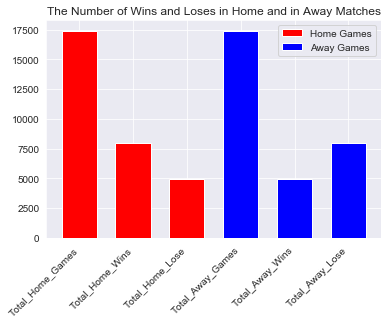

In [62]:
plt.bar(Home_Plot_Obj, Home_Plot_Val, color = 'r', width = 0.65, label = 'Home Games')
plt.bar(Away_Plot_Obj, Away_Plot_Val, color = 'b', width = 0.65, label = 'Away Games')
plt.xticks(rotation=45, ha = 'right')#set rotation angle of xticks for 45 degrees and its alignment to the right
plt.legend()
plt.title('The Number of Wins and Loses in Home and in Away Matches');

### Conclusion

The place of the match has a significant impact on the results of the match.

It is way more likely to win if a team playing at Home

.

# Is it more likely for a team with a bigger COR to win a match?

.

In [63]:
# as a reminder - The rows quantity is a matches quantity in the data frame
df_Match.shape

(17400, 8)

In [64]:
df_Match.head(2)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_Team_COR,Away_Team_COR
0,2008,499349,8722,9823,0,3,791.0,896.0
1,2008,539652,9885,8686,2,0,888.0,901.0


.

###### Lets calculate two counters
- COR_advantage - the number of matches when the team with bigger COR won the match
- COR_disadvantage - the number of matches when the team with bigger COR lost the match

.


In [65]:
# set the counters to zero
COR_advantage = 0
COR_disadvantage = 0
# for each row in the data frame
for row in range(df_Match.shape[0]):
    # increase the adv_counter by '1' if Home_team with bigger COR won the match
    if df_Match.at[row,'home_team_goal'] > df_Match.at[row,'away_team_goal'] and \
    df_Match.at[row,'Home_Team_COR'] > df_Match.at[row,'Away_Team_COR']:
        COR_advantage += 1
    # increase the adv_counter if Away_team with bigger COR won the match
    elif df_Match.at[row,'home_team_goal'] < df_Match.at[row,'away_team_goal'] and \
    df_Match.at[row,'Home_Team_COR'] < df_Match.at[row,'Away_Team_COR']:
        COR_advantage += 1
    # increase the disadv_counter by '1' if Home_team with bigger COR lost the match    
    if df_Match.at[row,'home_team_goal'] < df_Match.at[row,'away_team_goal'] and \
    df_Match.at[row,'Home_Team_COR'] > df_Match.at[row,'Away_Team_COR']:
        COR_disadvantage += 1
    # increase the disadv_counter if Away_team with bigger COR lost the match
    elif df_Match.at[row,'home_team_goal'] > df_Match.at[row,'away_team_goal'] and \
    df_Match.at[row,'Home_Team_COR'] < df_Match.at[row,'Away_Team_COR']:
        COR_disadvantage += 1
    
    


In [66]:
# total number of matches
Total_Matches = df_Match.shape[0]

In [67]:
#the ratio of matches when team with bigger COR won
Bigger_COR_Wins = COR_advantage / Total_Matches

In [68]:
#the ratio of matches when team with lower COR won
Low_COR_Wins = COR_disadvantage / Total_Matches

In [69]:
#the ratio of matches with draw
COR_Draw = (Total_Matches - (COR_advantage + COR_disadvantage)) / Total_Matches

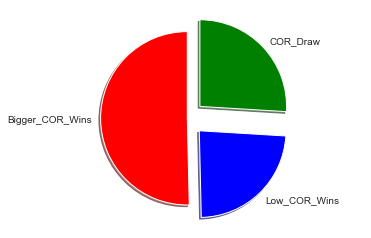

In [70]:
# Pie chart
labels = ['Bigger_COR_Wins', 'Low_COR_Wins', 'COR_Draw'] # list of labels
sizes = [Bigger_COR_Wins, Low_COR_Wins, COR_Draw ] # list of sizes of slices
explode = (0, 0.2, 0.2)  # "explode" the 2nd and 3rd slices     
colors = ['red', 'blue', 'green'] # colors of slices
plt.pie(sizes, explode = explode, colors = colors, labels = labels, shadow = True, startangle = 90)
plt.axis('equal'); # set aspect ration as equal to make sure the pie is drawn as a circle

### Conclusion

The rating of each player in a team means a lot in match results

It is more likely to win if a team has a bigger Combined Overall Rating

.

# How the match results correlate with COR?

.

Lets separate teams on different groups based on the size of its COR


In [71]:
df_Match['Home_Team_COR'].describe()

count    17400.000000
mean       798.699943
std         59.235455
min        610.000000
25%        759.750000
50%        804.000000
75%        838.000000
max        959.000000
Name: Home_Team_COR, dtype: float64

#### Define the Groups of teams based on its COR
- **Group-1** - label for teams with 838 < COR < 959
- **Group-2** - label for teams with 804 < COR < 838
- **Group-3** - label for teams with 759 < COR < 804
- **Group-4** - label for teams with 610 < COR < 759


Create a new column **"COR_Group"** in 'df_Team' data frame and assign its values, based on values in column 'Home_Team_COR' in 'df_Match' data frame.

.

In [72]:
df_Team.head(1)

,team_api_id,team_long_name,team_short_name,Home_Games,Away_Games,Total_Games,Home_Wins,Home_Lose,Away_Wins,Away_Lose
0,9987,KRC Genk,GEN,71.0,67.0,138.0,44.0,13.0,19.0,23.0


In [73]:
df_Match.head(1)

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_Team_COR,Away_Team_COR
0,2008,499349,8722,9823,0,3,791.0,896.0


Now, for each team_id we take the mean of its COR from data in column 'Home_Team_COR' in the 'df_Match' data frame
Then we compare that mean_COR value with the ranges of COR_Groups defined above. If the mean_COR value of specified 'team_id' is among a range of particular 'COR_Group', we assign the name of 'COR_Group' to this team


In [74]:
for id in df_Team['team_api_id'].tolist():
    if df_Match['Home_Team_COR'].min() < df_Match.loc\
    [df_Match['home_team_api_id'] == id, 'Home_Team_COR'].mean() < np.percentile(df_Match['Home_Team_COR'], 25):
        df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'COR_Group'] = 'Group-4'
    elif np.percentile(df_Match['Home_Team_COR'], 25) < df_Match.loc\
    [df_Match['home_team_api_id'] == id, 'Home_Team_COR'].mean() < np.percentile(df_Match['Home_Team_COR'], 50):
        df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'COR_Group'] = 'Group-3'
    elif np.percentile(df_Match['Home_Team_COR'], 50) < df_Match.loc\
    [df_Match['home_team_api_id'] == id, 'Home_Team_COR'].mean() < np.percentile(df_Match['Home_Team_COR'], 75):
        df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'COR_Group'] = 'Group-2'
    elif np.percentile(df_Match['Home_Team_COR'], 75) < df_Match.loc\
    [df_Match['home_team_api_id'] == id, 'Home_Team_COR'].mean() < df_Match['Home_Team_COR'].max():
        df_Team.at[df_Team[df_Team['team_api_id'] == id].index.item(),'COR_Group'] = 'Group-1'
   


In [75]:
df_Team.head(2)

,team_api_id,team_long_name,team_short_name,Home_Games,Away_Games,Total_Games,Home_Wins,Home_Lose,Away_Wins,Away_Lose,COR_Group
0,9987,KRC Genk,GEN,71.0,67.0,138.0,44.0,13.0,19.0,23.0,Group-3
1,9993,Beerschot AC,BAC,34.0,37.0,71.0,11.0,13.0,5.0,26.0,Group-4


In [76]:
# add columns 'Home_Draw' and 'Away_Draw' to 'df_Team' data frame
df_Team['Home_Draw'] = df_Team['Home_Games'] - df_Team['Home_Wins'] - df_Team['Home_Lose']
df_Team['Away_Draw'] = df_Team['Away_Games'] - df_Team['Away_Wins'] - df_Team['Away_Lose']

In [77]:
# form new data frame out of df_Team data frame, 
#where columns 'Home_Wins','Home_Lose','Home_Draw' are grouped by COUR_Group
Home_Group_Res = df_Team.groupby('COR_Group').mean()[['Home_Wins','Home_Lose','Home_Draw']]; Home_Group_Res

,Home_Wins,Home_Lose,Home_Draw
COR_Group,,,
Group-1,74.303030,19.090909,24.333333
Group-2,39.655172,27.775862,24.862069
Group-3,20.436782,14.689655,12.758621
Group-4,13.757009,13.607477,9.981308


In [78]:
# form new data frame out of df_Team data frame, 
#where columns 'Away_Wins','Away_Lose', 'Away_Draw' are grouped by COUR_Group
Away_Group_Res = df_Team.groupby('COR_Group').mean()[['Away_Wins','Away_Lose', 'Away_Draw']]; Away_Group_Res

,Away_Wins,Away_Lose,Away_Draw
COR_Group,,,
Group-1,50.545455,37.878788,30.757576
Group-2,22.706897,45.413793,23.810345
Group-3,12.459770,23.448276,11.919540
Group-4,8.467290,19.420561,9.252336


Results of Group-Teams played at HOME


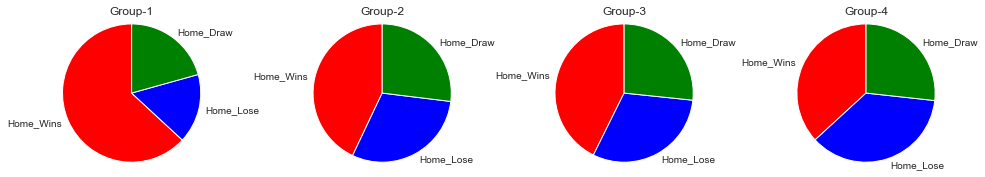

In [79]:
print("Results of Group-Teams played at HOME")
labels = ['Home_Wins','Home_Lose','Home_Draw']
HGR_1_size = Home_Group_Res.iloc[0,:].tolist()
HGR_2_size = Home_Group_Res.iloc[1,:].tolist()
HGR_3_size = Home_Group_Res.iloc[2,:].tolist()
HGR_4_size = Home_Group_Res.iloc[3,:].tolist()
colors = ['red', 'blue', 'green']

fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)# add axes to figure and set demensions(aka coordinates in a field)
ax1.pie(HGR_1_size, labels=labels, radius = 1.2, colors = colors,  startangle = 90)
ax1.set_title('Group-1')

ax2 = fig.add_axes([.58, .0, .5, .5], aspect=1)
ax2.pie(HGR_2_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax2.set_title('Group-2')

ax3 = fig.add_axes([1.14, .0, .5, .5], aspect=1)
ax3.pie(HGR_3_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax3.set_title('Group-3')

ax4 = fig.add_axes([1.70, .0, .5, .5], aspect=1)
ax4.pie(HGR_4_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax4.set_title('Group-4')
plt.show()

Results of Group-Teams played AWAY


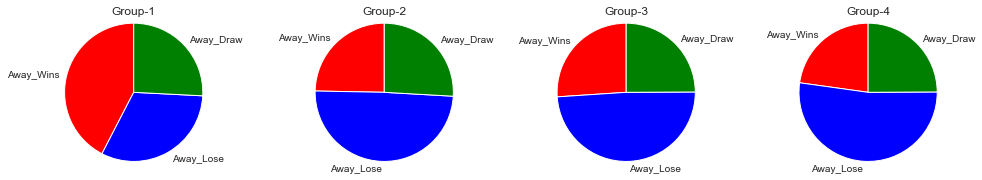

In [80]:
print("Results of Group-Teams played AWAY")
labels = ['Away_Wins','Away_Lose','Away_Draw']
AGR_1_size = Away_Group_Res.iloc[0,:].tolist()
AGR_2_size = Away_Group_Res.iloc[1,:].tolist()
AGR_3_size = Away_Group_Res.iloc[2,:].tolist()
AGR_4_size = Away_Group_Res.iloc[3,:].tolist()
colors = ['red', 'blue', 'green']

fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(AGR_1_size, labels=labels, radius = 1.2, colors = colors,  startangle = 90)
ax1.set_title('Group-1')

ax2 = fig.add_axes([.58, .0, .5, .5], aspect=1)
ax2.pie(AGR_2_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax2.set_title('Group-2')

ax3 = fig.add_axes([1.14, .0, .5, .5], aspect=1)
ax3.pie(AGR_3_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax3.set_title('Group-3')

ax4 = fig.add_axes([1.7, .0, .5, .5], aspect=1)
ax4.pie(AGR_4_size, labels=labels, radius = 1.2, colors = colors, startangle = 90)
ax4.set_title('Group-4')
plt.show()

.

### Conclusion

> We can say with confidence:
>- Teams with bigger GOR shows much better results.
>- High COR teams able to realize their advantages to being at HOME better than teams with lower COR
>- High COR teams shows bigger wins percentage in matches played AWAY


<a id='conclusions'></a>
## Conclusions summary

#### Results:

We had three questions for this investigation of European Soccer Database. We performed data analysis and find answers. Here they are:
>**Is it more likely for a team to win in the home matches than in a way?**
>- The place of the match has a significant impact on the results of the match.
>- It is way more likely to win if a team playing at Home

>**If we form a Combined Overall Rating(Team_COR) of a team as a sum of Overall Ratings of each its players is it more likely for a team with a bigger COR to win a match?**
>- The rating of each player in a team means a lot in match results
>- It is more likely to win if a team has a bigger Combined Overall Rating

>**How the match results correlate with COR?**
> We can say with confidence:
>- Teams with bigger GOR shows much better results.
>- High COR teams able to realize their advantages to being at HOME better than teams with lower COR
>- High COR teams shows bigger wins percentage in matches played AWAY

#### Limitations:

In the given database, we have only one limitation which has an effect on our analysis
> - Not every team in Match database has data of player_id of its players, so we had to remove that matches from our data frame. It causes removing some teams from the df_Team data frame, so we have not a full stack of teams for analysis.
Despite the fact that some data were removed due to the data cleaning process, the number of removed data has no significant impact on the results.

.